## Graficas suavizadas

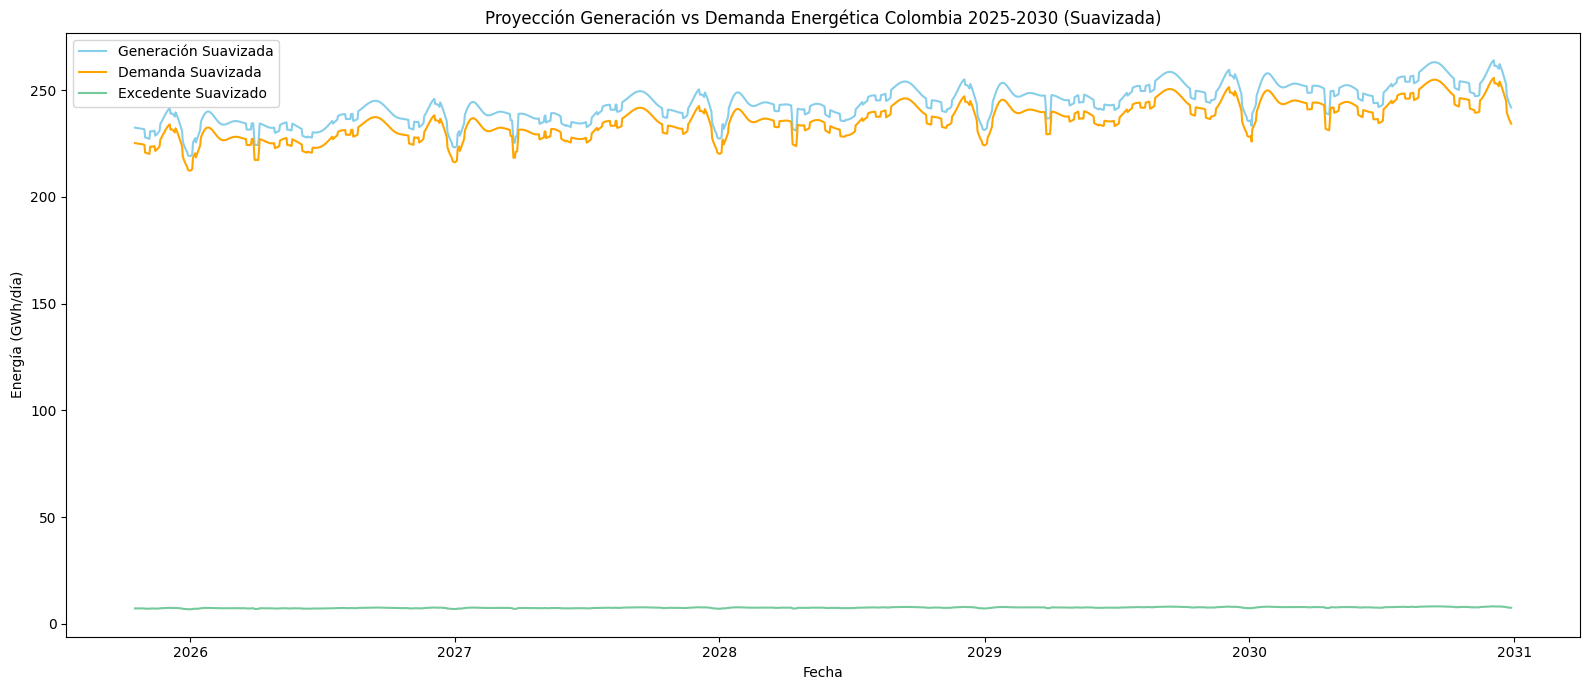

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv("predicciones_energia_2030_completo.csv")

# Renombrar columnas si es necesario (según tu archivo)
df.columns = ["Fecha", "GeneracionGWh", "DemandaGWh", "BalanceGWh"]
df["Fecha"] = pd.to_datetime(df["Fecha"])

# Aplicar promedio móvil de 7 días para suavizar las líneas
df["Generacion_suavizada"] = df["GeneracionGWh"].rolling(window=7, center=True).mean()
df["Demanda_suavizada"] = df["DemandaGWh"].rolling(window=7, center=True).mean()
df["Balance_suavizado"] = df["BalanceGWh"].rolling(window=7, center=True).mean()

# Graficar resultados suavizados
plt.figure(figsize=(16,7))
plt.plot(df["Fecha"], df["Generacion_suavizada"], label="Generación Suavizada", color="skyblue")
plt.plot(df["Fecha"], df["Demanda_suavizada"], label="Demanda Suavizada", color="orange")
plt.plot(df["Fecha"], df["Balance_suavizado"], label="Excedente Suavizado", color="mediumseagreen", alpha=0.7)
plt.title("Proyección Generación vs Demanda Energética Colombia 2025-2030 (Suavizada)")
plt.xlabel("Fecha")
plt.ylabel("Energía (GWh/día)")
plt.legend()
plt.tight_layout()
plt.show()


## Analisis de correlación

Resumen de la diferencia (Generacion - Demanda):
count    1905.000000
mean        7.595081
std         0.456507
min         5.964222
25%         7.370545
50%         7.678974
75%         7.930630
max         8.503546
Name: Diferencia, dtype: float64

Resumen del factor proporcional (Demanda / Generacion):
count    1.905000e+03
mean     9.688015e-01
std      2.376755e-16
min      9.688015e-01
25%      9.688015e-01
50%      9.688015e-01
75%      9.688015e-01
max      9.688015e-01
Name: Factor_proporcional, dtype: float64

Correlación entre generación y demanda: 1.0000


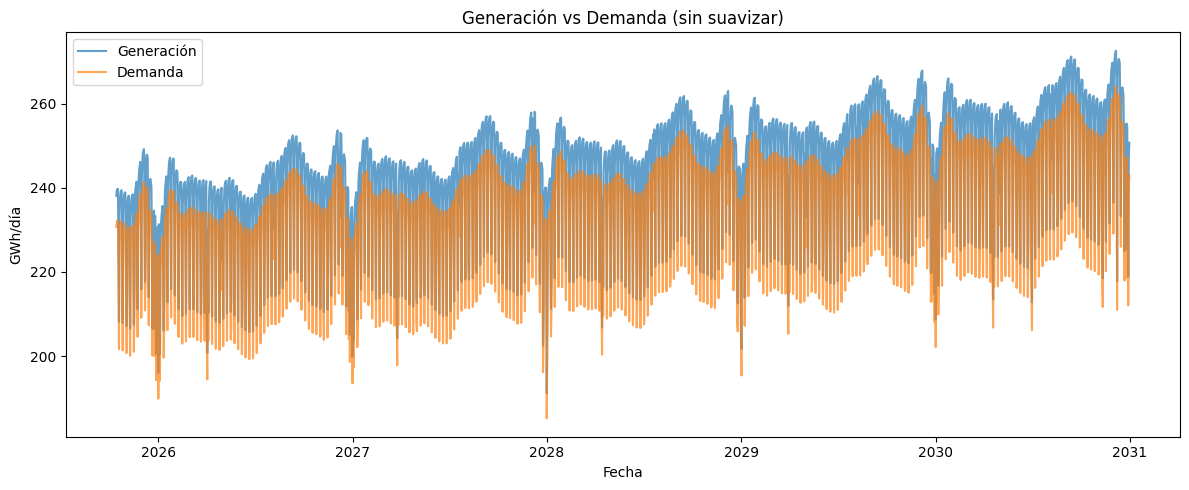

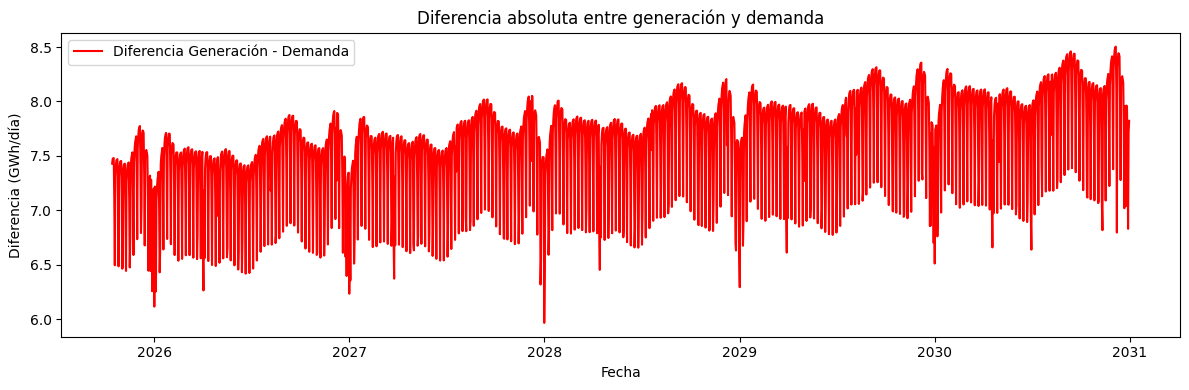

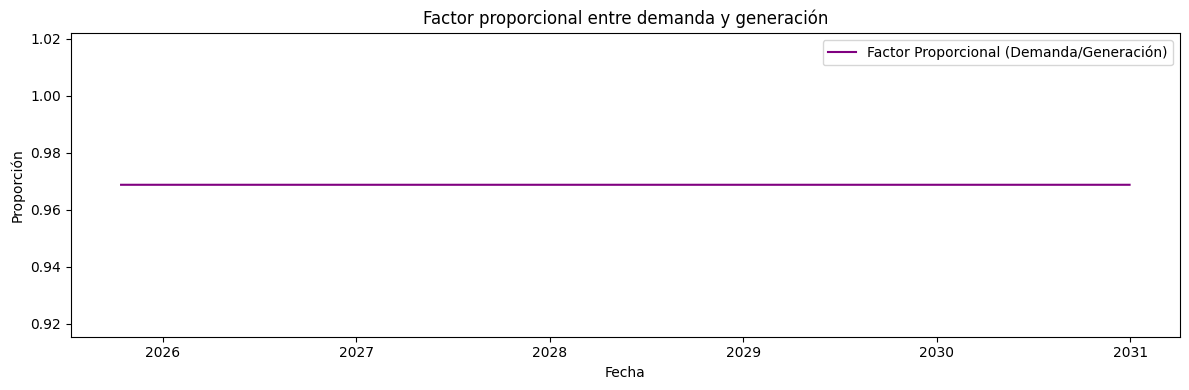

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos
df = pd.read_csv("predicciones_energia_2030_completo.csv")
df.columns = ["Fecha", "GeneracionGWh", "DemandaGWh", "BalanceGWh"]
df["Fecha"] = pd.to_datetime(df["Fecha"])

# Analizar diferencias absolutas y proporcionales
df["Diferencia"] = df["GeneracionGWh"] - df["DemandaGWh"]
df["Factor_proporcional"] = df["DemandaGWh"] / df["GeneracionGWh"]

print("Resumen de la diferencia (Generacion - Demanda):")
print(df["Diferencia"].describe())

print("\nResumen del factor proporcional (Demanda / Generacion):")
print(df["Factor_proporcional"].describe())

# Calcular correlación entre las series
corr = df["GeneracionGWh"].corr(df["DemandaGWh"])
print(f"\nCorrelación entre generación y demanda: {corr:.4f}")

# Graficar para visualizar la relación y diferencias
plt.figure(figsize=(12,5))
plt.plot(df["Fecha"], df["GeneracionGWh"], label="Generación", alpha=0.7)
plt.plot(df["Fecha"], df["DemandaGWh"], label="Demanda", alpha=0.7)
plt.title("Generación vs Demanda (sin suavizar)")
plt.xlabel("Fecha")
plt.ylabel("GWh/día")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["Fecha"], df["Diferencia"], color="red", label="Diferencia Generación - Demanda")
plt.title("Diferencia absoluta entre generación y demanda")
plt.xlabel("Fecha")
plt.ylabel("Diferencia (GWh/día)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["Fecha"], df["Factor_proporcional"], color="purple", label="Factor Proporcional (Demanda/Generación)")
plt.title("Factor proporcional entre demanda y generación")
plt.xlabel("Fecha")
plt.ylabel("Proporción")
plt.legend()
plt.tight_layout()
plt.show()


## Nuevo modelo de demanda

In [7]:
df = pd.read_csv("Demanda.csv")  # Convierte el PDF a CSV para esto
df

,FechaHora,Valor
0,2023-06-01T23:00:00,5106.44
1,2023-06-01T22:00:00,5106.82
2,2023-06-01T21:00:00,5104.55
3,2023-06-01T20:00:00,5095.07
4,2023-06-01T19:00:00,5096.44
...,...,...
3349603,2022-11-26T04:00:00,749.75
3349604,2022-11-26T03:00:00,770.69
3349605,2022-11-26T02:00:00,823.09
3349606,2022-11-26T01:00:00,862.68


20:25:55 - cmdstanpy - INFO - Chain [1] start processing
20:25:55 - cmdstanpy - INFO - Chain [1] done processing


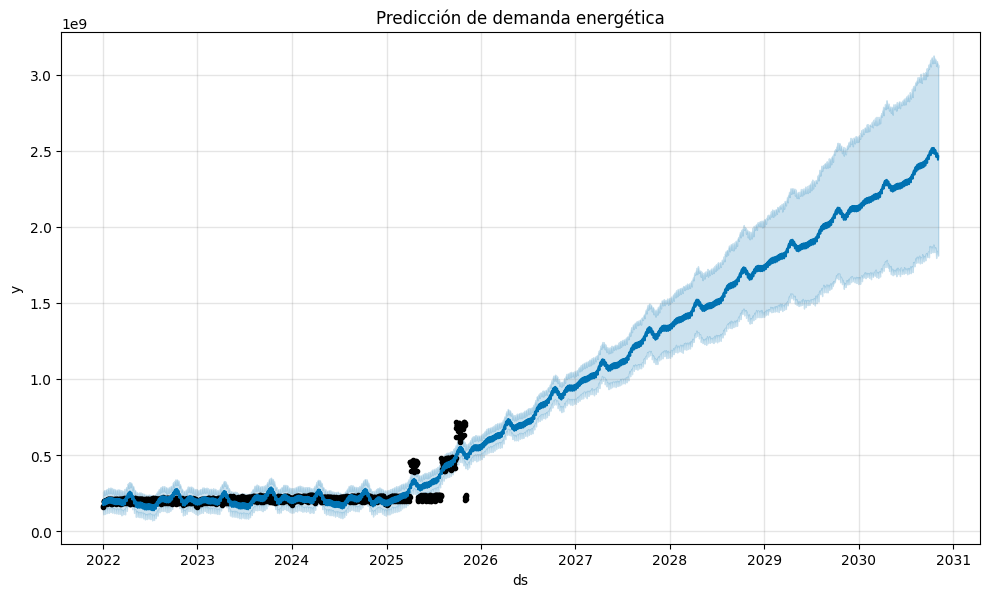

In [16]:
import pandas as pd
from prophet import Prophet

# 1. Cargar y limpiar la base de datos
df = pd.read_csv("Demanda.csv")
df["FechaHora"] = pd.to_datetime(df["FechaHora"], errors="coerce")

# 2. Agregar a nivel diario (si hay varias horas por día)
df['Fecha'] = df["FechaHora"].dt.date
df_diario = df.groupby('Fecha')['Valor'].sum().reset_index()

# 3. Preparar columna para Prophet
df_prophet = df_diario.rename(columns={'Fecha': 'ds', 'Valor': 'y'})  # CORREGIDO

# 4. Ajustar modelo y predecir
model = Prophet()
model.fit(df_prophet)

# 5. Generar fechas futuras hasta 2030
years_ahead = 2030 - pd.to_datetime(df_prophet['ds']).max().year
days_ahead = years_ahead * 365
future = model.make_future_dataframe(periods=days_ahead)
forecast = model.predict(future)

# 6. Visualización
model.plot(forecast)
plt.title("Predicción de demanda energética")
plt.show()

# 7. Exportar predicción
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('prediccion_demanda_2030_prophet.csv', index=False)


## Datos reales vs Predicción

20:24:59 - cmdstanpy - INFO - Chain [1] start processing
20:24:59 - cmdstanpy - INFO - Chain [1] done processing


MAE en el conjunto de test: 142081774.36
RMSE en el conjunto de test: 166337054.68


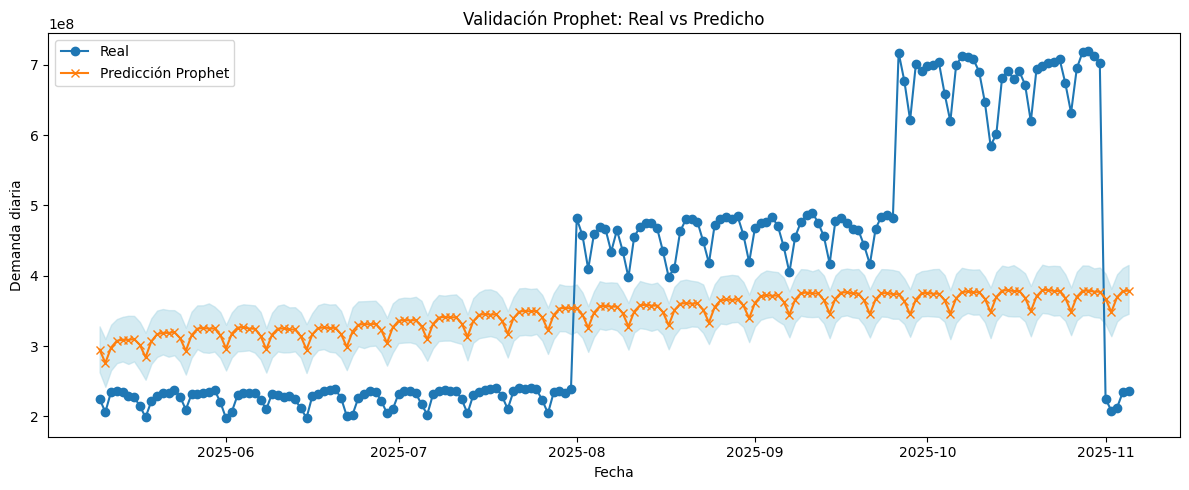

In [13]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Leer y preparar los datos como antes
df = pd.read_csv("Demanda.csv")
df["FechaHora"] = pd.to_datetime(df["FechaHora"], errors="coerce")
df['Fecha'] = df["FechaHora"].dt.date
df_diario = df.groupby('Fecha')['Valor'].sum().reset_index()
df_prophet = df_diario.rename(columns={'Fecha': 'ds', 'Valor': 'y'})

# Separar entrenamiento y test (últimos 6 meses como test)
split_date = pd.to_datetime(df_prophet['ds']).max() - pd.Timedelta(days=180)
train = df_prophet[pd.to_datetime(df_prophet['ds']) <= split_date]
test = df_prophet[pd.to_datetime(df_prophet['ds']) > split_date]

# Ajustar modelo solo con entrenamiento
model = Prophet()
model.fit(train)

# Predecir sobre el intervalo completo (entreno+test) para facilitar comparación visual
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Extraer solo predicciones de test
forecast_test = forecast[-len(test):]
test = test.reset_index(drop=True)

# Calcular métricas de error
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))

print(f"MAE en el conjunto de test: {mae:.2f}")
print(f"RMSE en el conjunto de test: {rmse:.2f}")

# Visualizar real vs predicción en test
plt.figure(figsize=(12,5))
plt.plot(test['ds'], test['y'], label='Real', marker='o')
plt.plot(test['ds'], forecast_test['yhat'], label='Predicción Prophet', marker='x')
plt.fill_between(test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='lightblue', alpha=0.5)
plt.title("Validación Prophet: Real vs Predicho")
plt.xlabel("Fecha")
plt.ylabel("Demanda diaria")
plt.legend()
plt.tight_layout()
plt.show()


## Modelo mejorado

In [14]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])


20:26:14 - cmdstanpy - INFO - Chain [1] start processing
20:26:14 - cmdstanpy - INFO - Chain [1] done processing


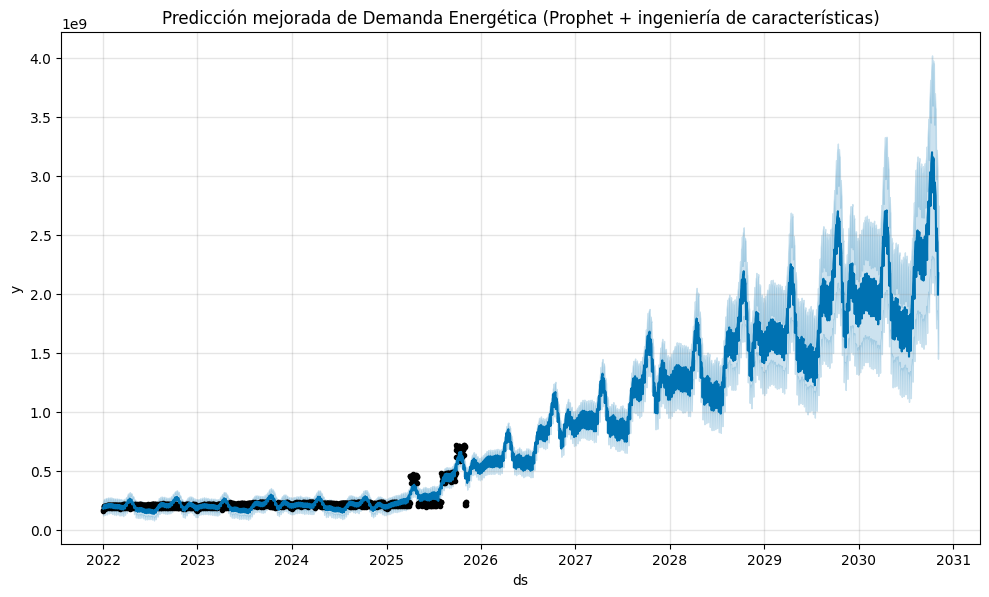

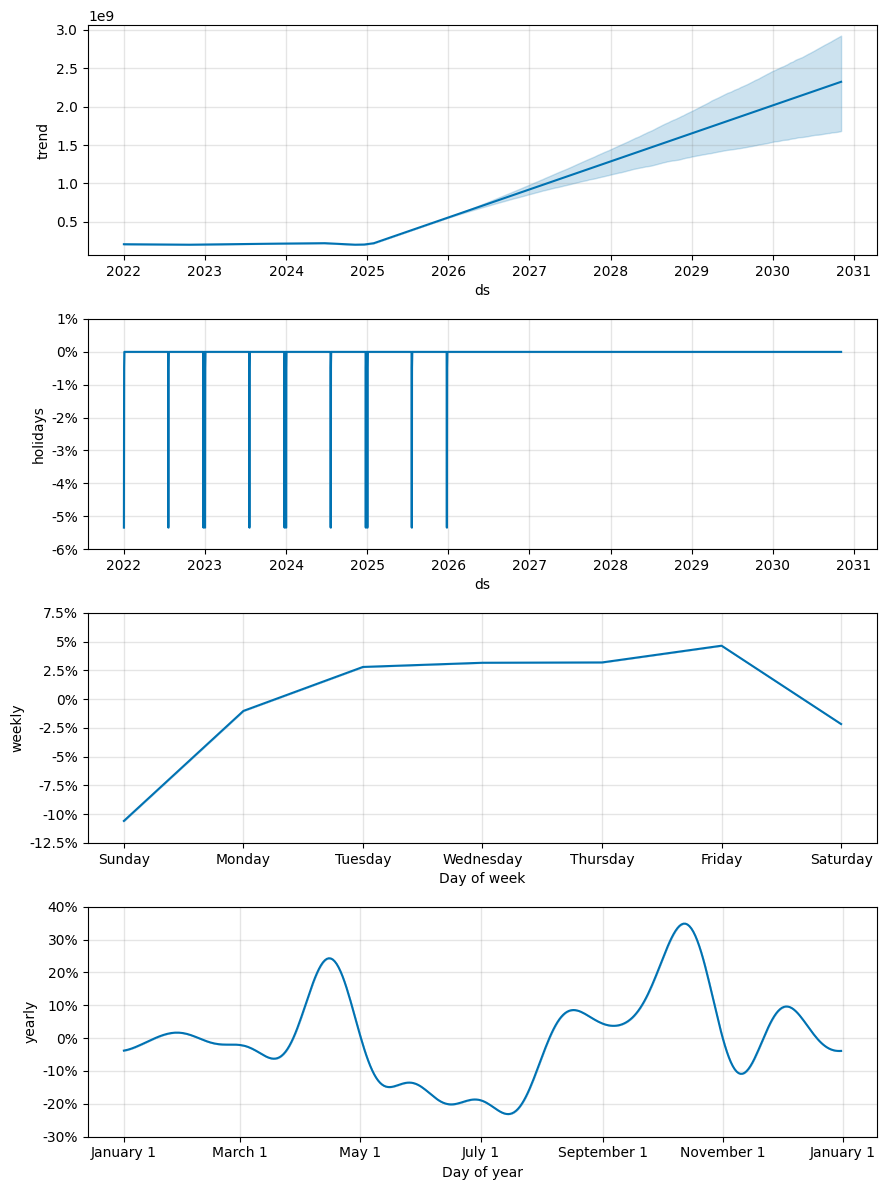

ValueError: You are trying to merge on object and datetime64[ns] columns for key 'ds'. If you wish to proceed you should use pd.concat

In [17]:
import pandas as pd
from prophet import Prophet
import numpy as np

# Preparación y limpieza
df = pd.read_csv("Demanda.csv")
df["FechaHora"] = pd.to_datetime(df["FechaHora"], errors="coerce")
df['Fecha'] = df["FechaHora"].dt.date
df_diario = df.groupby('Fecha')['Valor'].sum().reset_index()
df_prophet = df_diario.rename(columns={'Fecha': 'ds', 'Valor': 'y'})

# Festivos para Colombia (puedes ampliar la lista)
def obtener_festivos_colombia(year):
    festivos = [
        pd.to_datetime(f'{year}-01-01'),
        pd.to_datetime(f'{year}-07-20'),
        pd.to_datetime(f'{year}-12-25'),
    ]
    return pd.DataFrame({'holiday': 'colombia_holiday', 'ds': festivos, 'lower_window': 0, 'upper_window': 1})

años = range(df_prophet['ds'].min().year, df_prophet['ds'].max().year + 1)
festivos_df = pd.concat([obtener_festivos_colombia(year) for year in años])
festivos_df = festivos_df.drop_duplicates(subset=['ds']).reset_index(drop=True)

# Entrenamiento del modelo Prophet con ingeniería de características
modelo = Prophet(
    holidays=festivos_df,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

# Si tienes variables externas, agrégalas aquí:
# modelo.add_regressor('temperatura')
# modelo.add_regressor('indice_economico')
# ...

modelo.fit(df_prophet)

# Predicción futura (ajusta 'dias_futuros' según tu necesidad)
dias_futuros = 365 * (2030 - df_prophet['ds'].max().year)
future = modelo.make_future_dataframe(periods=dias_futuros)
# Si agregaste regresores, deberás añadir las columnas respectivas en 'future'

forecast = modelo.predict(future)

# Visualización
fig = modelo.plot(forecast)
plt.title('Predicción mejorada de Demanda Energética (Prophet + ingeniería de características)')
plt.show()
fig_components = modelo.plot_components(forecast)
plt.show()

# Evaluación histórica (MAE, RMSE, R2)
df_pred = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds', how='inner')
y_true = df_pred['y']
y_pred = df_pred['yhat']

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")


20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing



--- Métricas de Evaluación Histórica ---
1. MAE (Error Absoluto Medio): 28,577,712.86
2. RMSE (Raíz del Error Cuadrático Medio): 41,714,883.07
3. R^2 (Coeficiente de Determinación): 0.7981
Bueno, pero se puede mejorar incluyendo más variables.


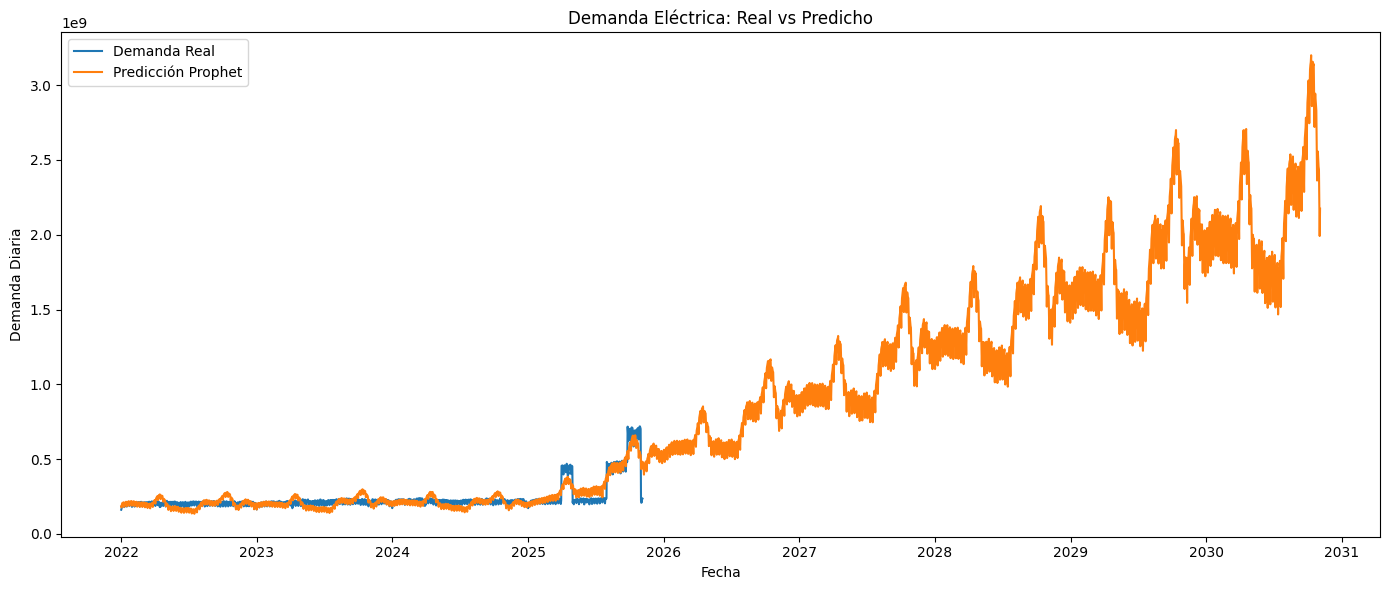

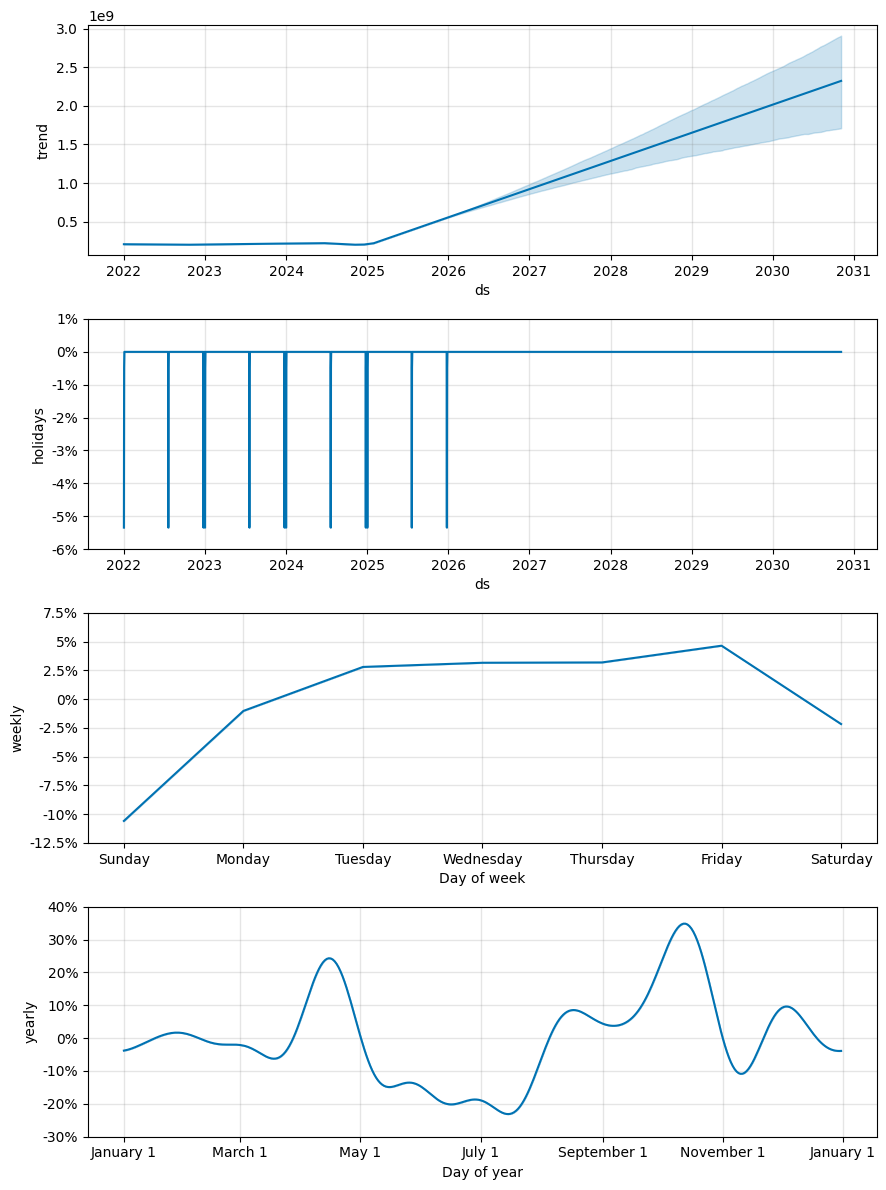

In [18]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Lectura y preparación de los datos crudos
df = pd.read_csv("Demanda.csv")  # Debe tener columnas 'FechaHora' y 'Valor'
df['FechaHora'] = pd.to_datetime(df['FechaHora'], errors='coerce')

# 2. Agregación diaria
df['Fecha'] = df['FechaHora'].dt.date
df_diario = df.groupby('Fecha')['Valor'].sum().reset_index()

# 3. Formato para Prophet
df_prophet = df_diario.rename(columns={'Fecha': 'ds', 'Valor': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])  # <-- conversión crucial

# 4. Ingeniería de características: festivos simulados Colombia
def obtener_festivos_colombia(year):
    festivos = [
        pd.to_datetime(f'{year}-01-01'),
        pd.to_datetime(f'{year}-07-20'),
        pd.to_datetime(f'{year}-12-25'),
    ]
    return pd.DataFrame({'holiday': 'colombia_holiday', 'ds': festivos, 'lower_window': 0, 'upper_window': 1})

años = range(df_prophet['ds'].min().year, df_prophet['ds'].max().year + 1)
festivos_df = pd.concat([obtener_festivos_colombia(year) for year in años])
festivos_df = festivos_df.drop_duplicates(subset=['ds']).reset_index(drop=True)

# 5. Entrenamiento del modelo
modelo = Prophet(
    holidays=festivos_df,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
modelo.fit(df_prophet)

# 6. Predicción futura
dias_futuros = 365 * (2030 - df_prophet['ds'].max().year)  # cantidad de días hasta 2030
future = modelo.make_future_dataframe(periods=dias_futuros)
forecast = modelo.predict(future)
forecast['ds'] = pd.to_datetime(forecast['ds'])  # <-- conversión asegurada

# 7. Evaluación: comparación histórica
df_pred = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds', how='inner')

y_true = df_pred['y']
y_pred = df_pred['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\n--- Métricas de Evaluación Histórica ---")
print(f"1. MAE (Error Absoluto Medio): {mae:,.2f}")
print(f"2. RMSE (Raíz del Error Cuadrático Medio): {rmse:,.2f}")
print(f"3. R^2 (Coeficiente de Determinación): {r2:.4f}")

# Interpretación básica
if r2 > 0.8:
    print("¡Excelente! El modelo explica la mayor parte de la variabilidad.")
elif r2 > 0.5:
    print("Bueno, pero se puede mejorar incluyendo más variables.")
else:
    print("El modelo explica poco. Considera limpiar datos o añadir regresores.")

# 8. Visualización
plt.figure(figsize=(14,6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Demanda Real')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicción Prophet')
plt.title('Demanda Eléctrica: Real vs Predicho')
plt.xlabel('Fecha')
plt.ylabel('Demanda Diaria')
plt.legend()
plt.tight_layout()
plt.show()

# Componentes estacionales
modelo.plot_components(forecast)
plt.show()


In [37]:
df_capacidad = pd.read_csv('Capacidad.csv')
df_capacidad["Fecha"] = pd.to_datetime(df_capacidad["Fecha"], format="%d/%m/%Y")
df_capacidad = df_capacidad[df_capacidad["Fecha"] >= '2022']
df_capacidad = df_capacidad[['Fecha','Capacidad acumulada [MW]']].reset_index(drop=True)
df_capacidad.to_csv('Capacidad_fil.csv',index=False)
